# RUN PERFORMANCE PROJECT - Pau Sampietro  

## *Predicting future races:* DEEP LEARNING APPROACH

For the moment, The weighted linear regression is our best model to do predictions for future runs. Now, we want to try how Neural Networks could help us doing predictions. As a linear regression could be represented as a NN with no hidden layers, we want to try with some easy NN models, in order to try to get better predictions, but mainly to understand how Neural Networks works, and also what are epochs and learning rate and how to tune them.

We will work with an Enviroment (tensorflowEnv) specially created for this purpose, and we will use **tensorflow and keras**
to create our model. We also added a plugin to Juypter Notebook in order to switch between Conda enviroments

<img src="images/NN structure.jpeg">

*Examples of Regression workflow (**left**) and Neural Network with more deep structure (**right**)*

In [1]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from rpdb import read_table, read_table_sql, export_table

Using TensorFlow backend.


#### Import table moves from Pau from the Database 

In [2]:
moves = read_table('moves_feat')
moves.drop(columns='index', inplace=True)
moves.head()

,distance,accum_ascent,ascent_ratio,calories,heart_rate,days_from,moving_time
0,4019.0,280.0,69.7,670.0,166.0,659,29.8
1,4995.0,63.0,12.6,585.0,168.0,659,30.9
2,4374.0,115.0,26.3,602.0,180.0,642,22.6
3,3005.0,91.0,30.3,365.0,167.0,641,16.9
4,6540.0,241.0,36.9,760.0,161.0,637,42.0


### 1. Data preprocessing (Scaling input features & Train_Test Splitting)

In [3]:
X = moves[['distance', 'accum_ascent', 'ascent_ratio']]
y = moves['moving_time']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

### 2. First Approach to Neural Networks

In this case, we will try some values in order to understand the impact of the parameters above:
* **Learning rate**: controls how much to change the model in response to the estimated error each time the model weights are updated
* **Epochs**: Training your network on each item of the set once is an epoch

<img src="images/LR vs epoch.png">

As we have **really few data**, we will try to fit our model to a **very simple NN**, and tune the parameters in order to see if we could obtain such good results

#### 2.1. Testing Learning Rate [0.01, 0.1, 0.2, 1, 10] on a simple NN (No hidden layers)

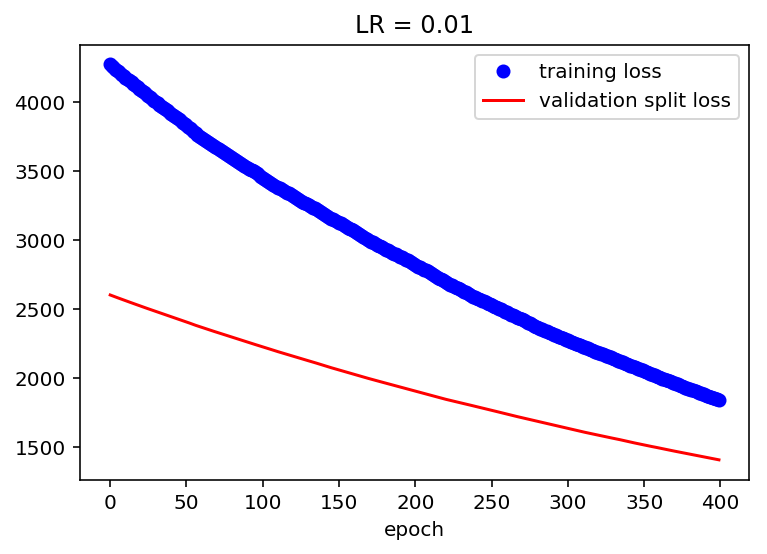

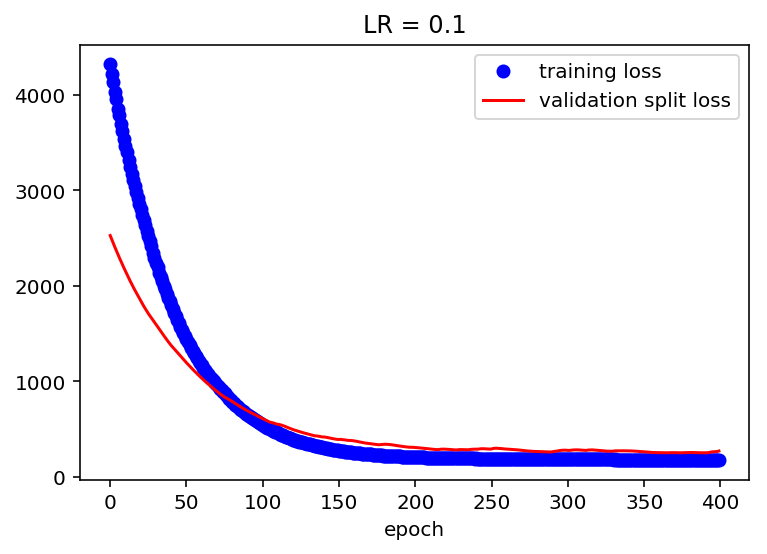

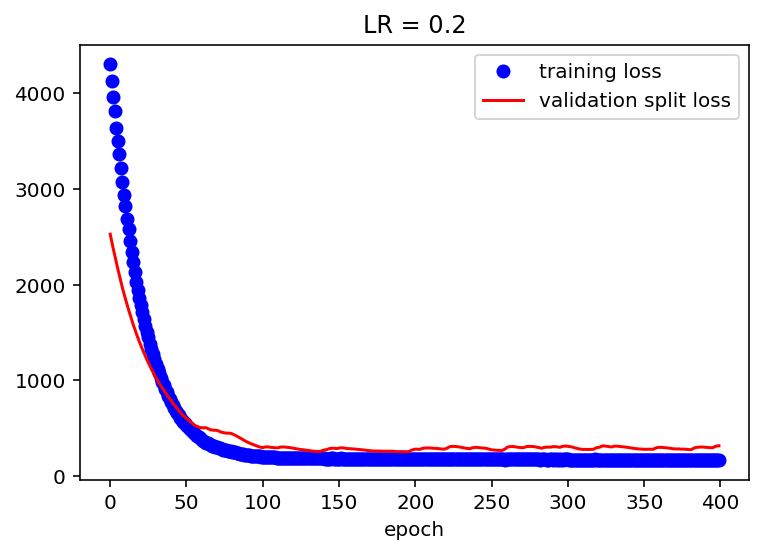

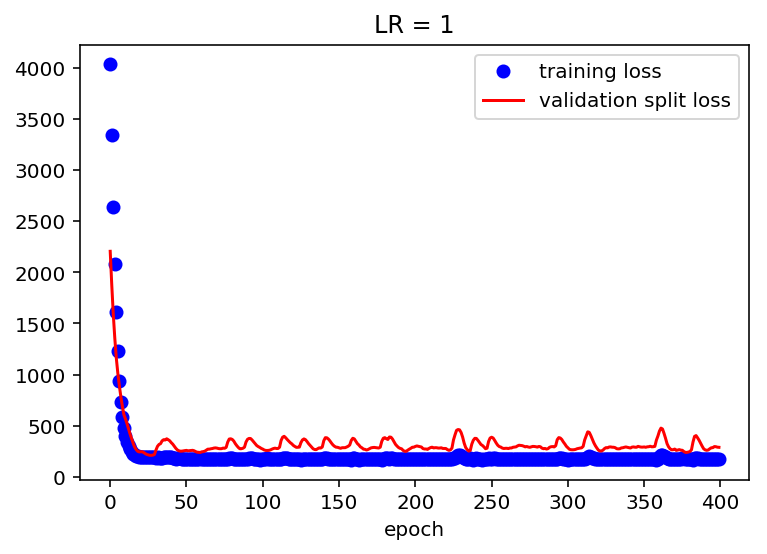

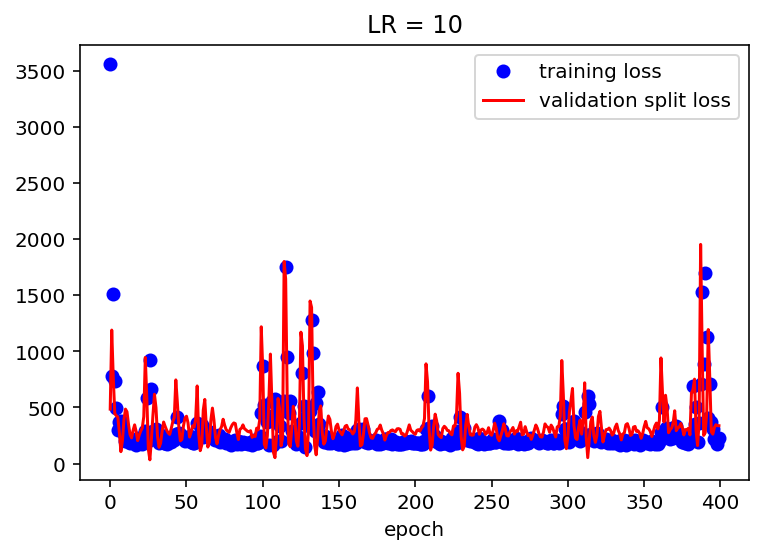

In [10]:
LR = [0.01, 0.1, 0.2, 1, 10]

for i in LR:
    # linear regression (NO HIDDEN LAYERS) model: Shape input: accum_ascent and distance, output movin_time
    model = Sequential()
    model.add(Dense(1, input_shape=(3,)))
    
    model.compile(Adam(lr=i), 'mean_squared_error')
    
    # fitting model
    history = model.fit(X_train, y_train, epochs = 400, validation_split = 0.1, verbose = 0)
    history_dict=history.history
    
    # plotting model's training cost/loss and model's validation split cost/loss
    loss_values = history_dict['loss']
    val_loss_values=history_dict['val_loss']
    plt.figure()
    plt.title(f'LR = {i}')
    plt.xlabel('epoch')
    plt.plot(loss_values,'bo',label='training loss')
    plt.plot(val_loss_values,'r',label='validation loss')
    plt.legend()

* We could se that increasing our Learning rate could cause that our model skip some optimals or even diverge. with LR=10, for example, we are overtraining our model

#### 2.2. Simple model performance with LR=0.2 and Epochs=400

Now we test a simple neural network without deep layers, in order to calculate some metrics as r2 scores with our parametrized NN.

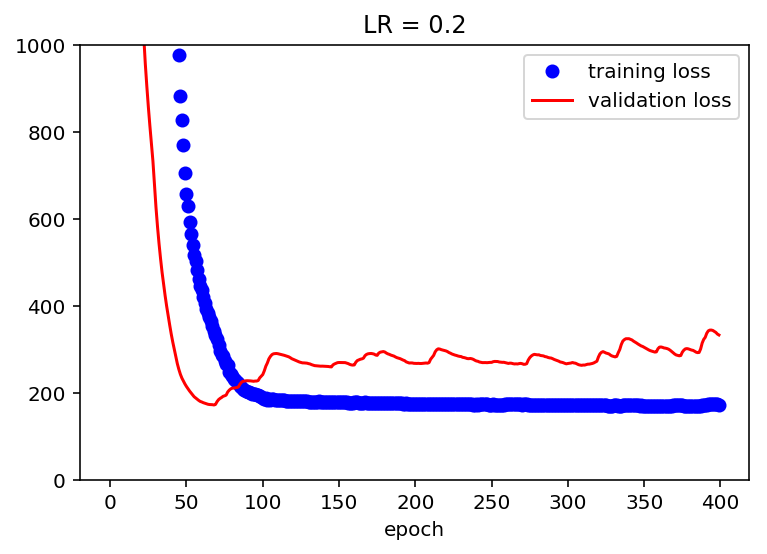

In [15]:
lr = 0.2
model = Sequential()
model.add(Dense(1, input_shape=(3,), activation = 'relu'))
model.compile(Adam(lr=lr), 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 400, validation_split = 0.1,verbose = 0)

history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='validation loss')
plt.title(f'LR = {lr}')
plt.xlabel('epoch')
plt.ylim((0,1000))
plt.legend()
plt.show()

In [16]:
# runs model 
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# prints r2_score of train/test sets
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	0.886
The R2 score on the Test set is:	0.622


As we could see, doing too many epochs cause the model starts overfitting and it is later badly guessing the y from the validation split. 

In the next attemp, we will add a function called **EarlyStopper**, that cuts the iterations when the slope of train loss is starting to rise over the validation split.

#### 2.3. Adding some Hidden Layers and testing the NN with 2 input features (with EarlyStopper function)

In [81]:
X = moves[['distance', 'ascent_ratio']]
y = moves['moving_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

Epoch 00474: early stopping


(0, 700)

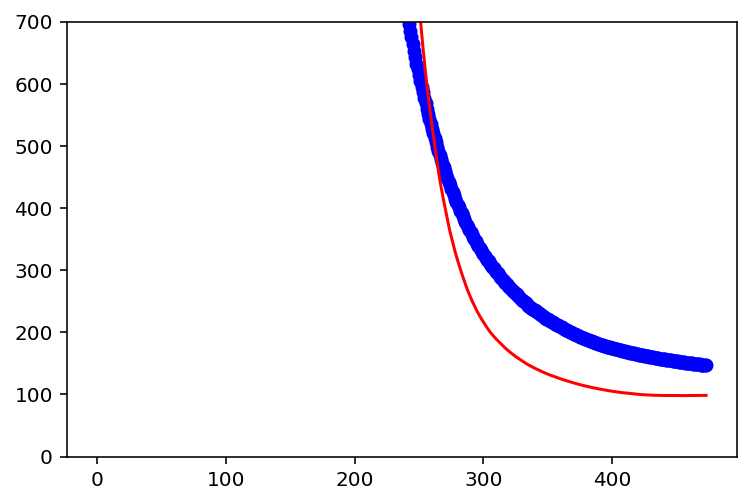

In [97]:
# Defines the model with 3 hidden layers of 13 nodes each, using activation function ReLu

model = Sequential()
model.add(Dense(13, input_shape=(2,), activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(1,))
model.compile(Adam(lr=0.0002), 'mean_squared_error')

#'EarlyStopping' function and its parameters
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Fits model over 500 iterations with 'earlystopper' callback, and assigns it to history
history = model.fit(X_train, y_train, epochs = 500, validation_split = 0.2, shuffle = True,
                    verbose = 0, callbacks = [earlystopper])

# Plots evolution of epochs and loss
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='validation loss')
plt.ylim(0,700)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [98]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	0.927
The R2 score on the Test set is:	0.594


In this case, the results are quite similar. Adding complexity to the NN **does not improves the model**, as we are using too few data. We are also giving only two inputs to the model, which makes difficult for the model to understand "hidden" patterns in the data. The model keeps overfitting

#### 2.4. Evaluating Results and giving predictions

Now we will plot the predictions provided by the model (on the train and test sets) compared to true values of outcome. As it is easy to see in the plot below, predictions in some cases are far away from the "optimal line" (y=x). This means that the NN are not giving the best results, specially for long distances. 

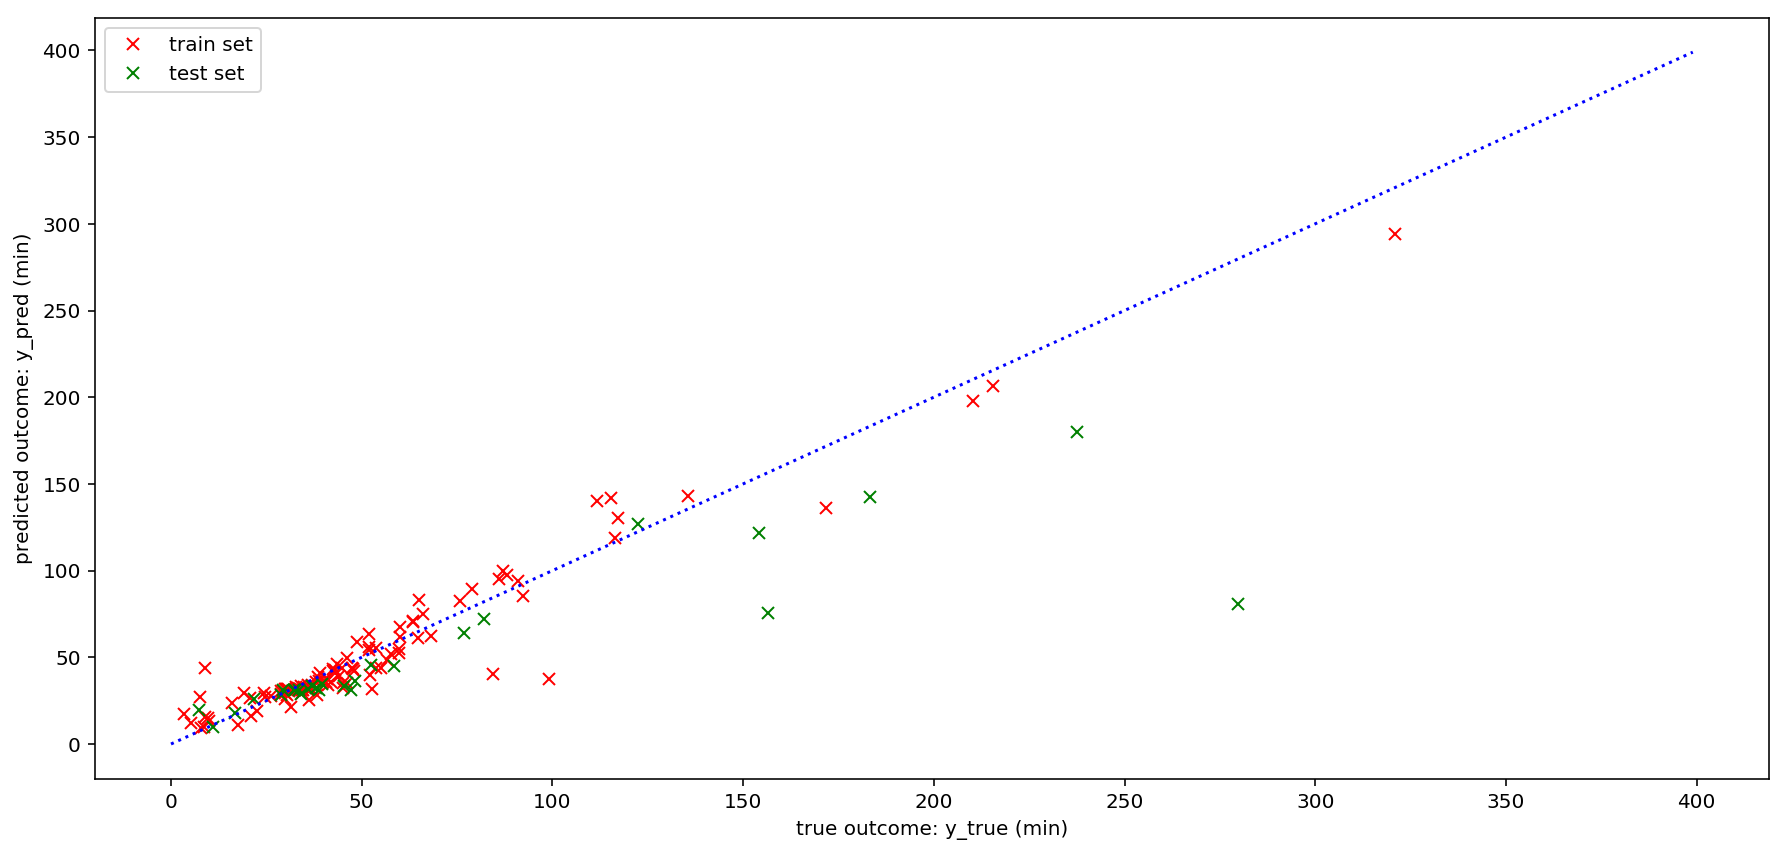

In [99]:
plt.figure (figsize=(15,7))
plt.plot(y_train, y_train_pred, 'xr', label='train set')
plt.plot(y_test, y_test_pred, 'xg', label = 'test set')
plt.plot([i for i in range(400)],[i for i in range(400)], ':b')
plt.xlabel('true outcome: y_true (min)')
plt.ylabel('predicted outcome: y_pred (min)')
plt.legend()

#### 2.5. Predicting moving time for given races

Once our NN is "trained", we import the data we want to pass trought the model in order to get some predictions

In [67]:
races = read_table('races')
races.head()

,index,name,distance,accum_ascent,days_from,lr_pred,kn_pred,lrW_pred
0,0,delta prat,10000.0,25.0,-13,36.639508,43.5,35.981029
1,1,catllaras,42300.0,2700.0,-27,452.950483,321.0,459.354518
2,2,stockholm,42195.0,172.0,-40,163.870622,321.0,160.165168
3,3,ulldeter,21000.0,1300.0,-62,219.990278,115.4,223.194372


In [68]:
races['ascent_ratio'] = races.apply(lambda x: round(x['accum_ascent']/(x['distance']/1000),1), axis = 1)

In [69]:
races

,index,name,distance,accum_ascent,days_from,lr_pred,kn_pred,lrW_pred,ascent_ratio
0,0,delta prat,10000.0,25.0,-13,36.639508,43.5,35.981029,2.5
1,1,catllaras,42300.0,2700.0,-27,452.950483,321.0,459.354518,63.8
2,2,stockholm,42195.0,172.0,-40,163.870622,321.0,160.165168,4.1
3,3,ulldeter,21000.0,1300.0,-62,219.990278,115.4,223.194372,61.9


In [100]:
X_races = preprocessing.scale(races[['distance','accum_ascent']])

In [101]:
races_nn_pred = model.predict(X_races)
print(f'* NN predictions for given races: {races_nn_pred}')

* NN predictions for given races: [[ 23.934484]
 [110.28208 ]
 [ 70.70378 ]
 [ 22.84685 ]]


****COMMENTS***: The results obtained do not seem to make any sense. In all the cases, the model is predicting a much more faster runner than Pau. In some outputs, the pace is not even possible in terms of human body. This is probably because we have too many data to train the NN, and also too few features. Althought this isn't for sure the best model, it has been an approach to tensorflow and keras tools, specially how to start using them for a quite simple goal.